In [ ]:
import sys
import os

src_path = os.path.abspath(os.path.join(os.pardir, "src"))
if src_path not in sys.path:
    sys.path.append(src_path)

from app import download_extract_zip_to_csv

download_extract_zip_to_csv(output_dir="../data")

Zip file downloaded successfully to: downloaded_data.zip
Extracting CSV files...
Found CSV file: Fake.csv
CSV file saved to: ../data/Fake.csv
Found CSV file: True.csv
CSV file saved to: ../data/True.csv
Deleted the downloaded zip file: downloaded_data.zip


True

[nltk_data] Downloading package punkt to /home/cquark/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/cquark/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Fechas no parseadas: 10
['https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/'
 'https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/'
 'https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/'
 'https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg'
 'https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg'
 'MSNBC HOST Rudely Assumes Steel Worker Would Never Let His Son Follow in His Footsteps…He Couldn’t Be More Wrong [Video]']
Numéricas: 7 ['text_length', 'title_length', 'num_exclamations', 'num_questions', 'num_uppercase_words', 'num_links', 'num_sentences']
Categóricas: 7 ['subject', 'month', 'weekday', 'title_has_exclamation', 'title_has_question', 'title_length_cat', 'title_has_link']
                       count         mean 

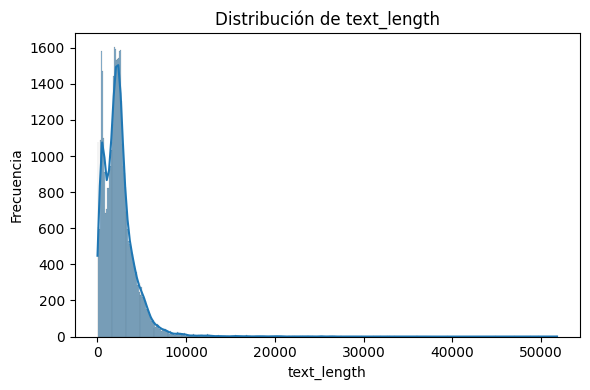

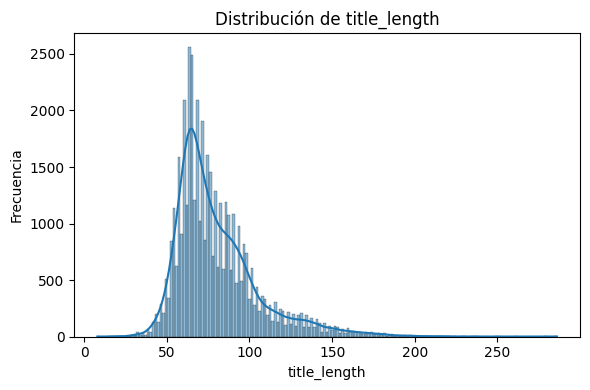

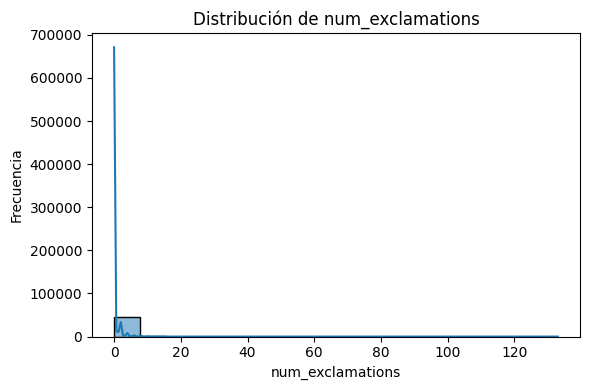

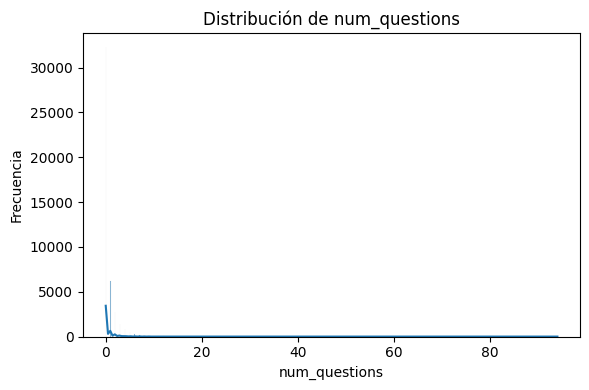

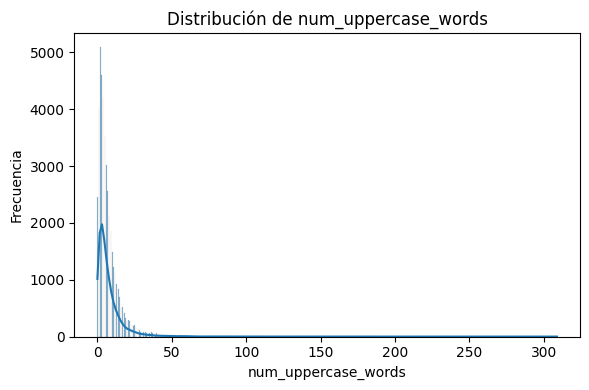

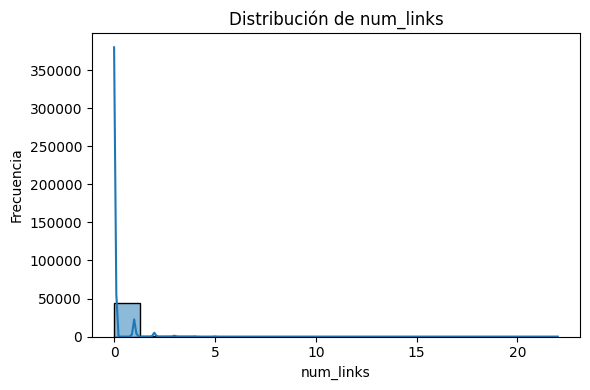

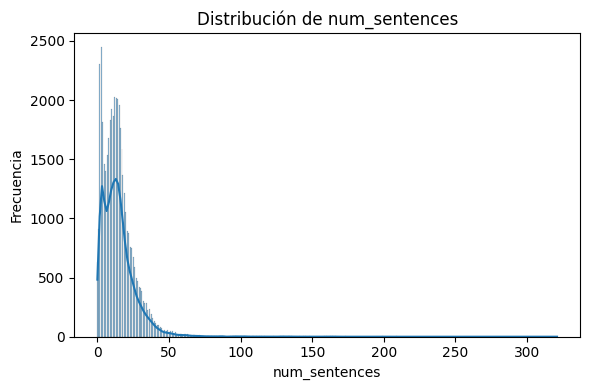


=== Distribución de subject ===


,count,percent
subject,,
politicsNews,11272,25.11
worldnews,10145,22.60
News,9050,20.16
politics,6841,15.24
left-news,4459,9.93
Government News,1570,3.50
US_News,783,1.74
Middle-east,778,1.73


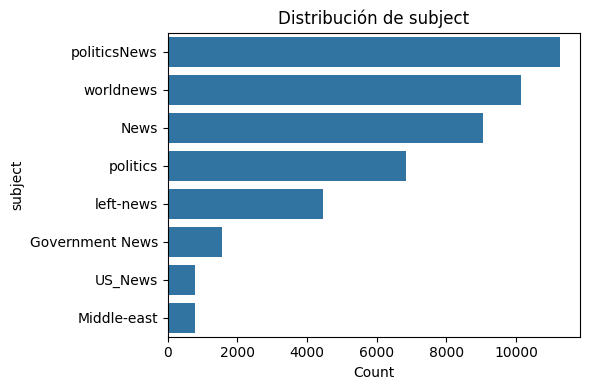


=== Distribución de month ===


,count,percent
month,,
11.0,5536,12.33
10.0,5476,12.20
9.0,5199,11.58
12.0,4614,10.28
3.0,3336,7.43
1.0,3106,6.92
5.0,3076,6.85
4.0,3034,6.76
2.0,2957,6.59


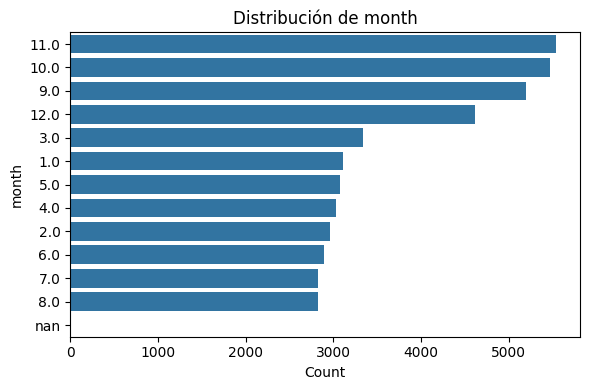


=== Distribución de weekday ===


,count,percent
weekday,,
Wednesday,7741,17.24
Thursday,7690,17.13
Tuesday,7275,16.20
Friday,7174,15.98
Monday,6373,14.19
Sunday,4495,10.01
Saturday,4140,9.22
NaN,10,0.02


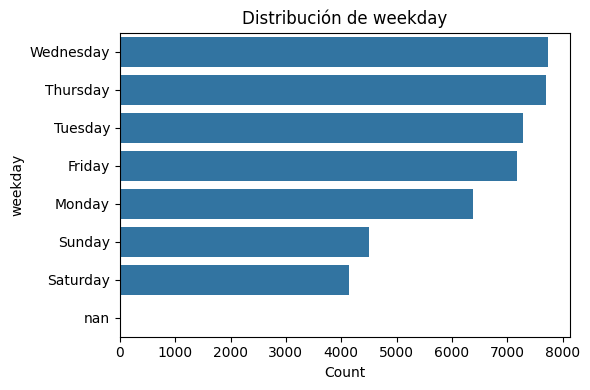


=== Distribución de title_has_exclamation ===


,count,percent
title_has_exclamation,,
no,41608,92.67
yes,3290,7.33


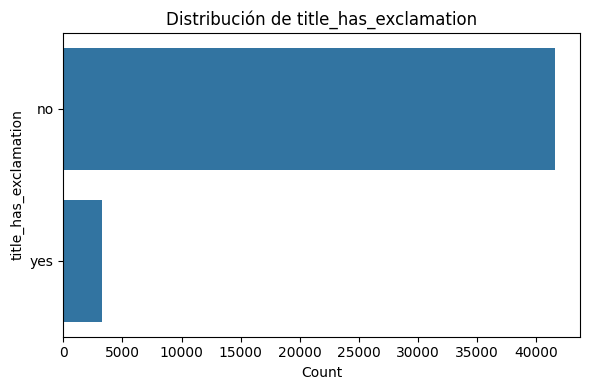


=== Distribución de title_has_question ===


,count,percent
title_has_question,,
no,43118,96.04
yes,1780,3.96


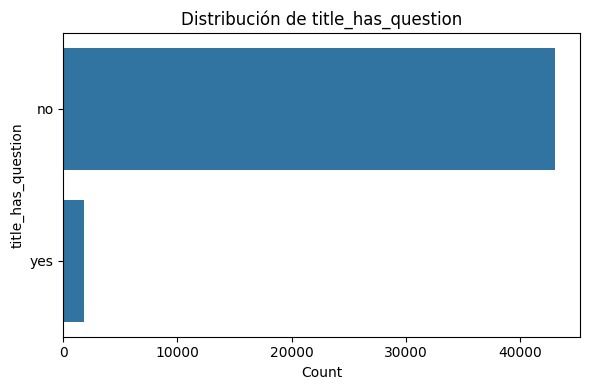


=== Distribución de title_length_cat ===


,count,percent
title_length_cat,,
long,25094,55.89
medium,19762,44.02
short,42,0.09


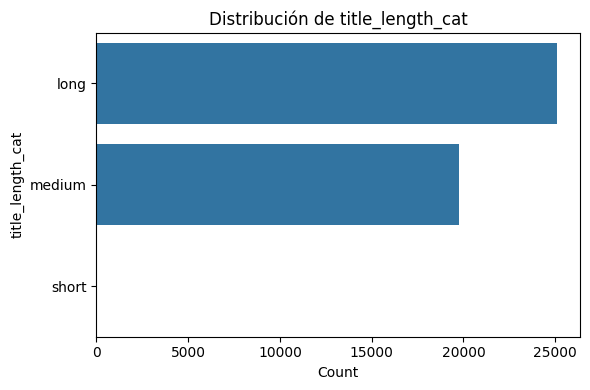


=== Distribución de title_has_link ===


,count,percent
title_has_link,,
no,44889,99.98
yes,9,0.02


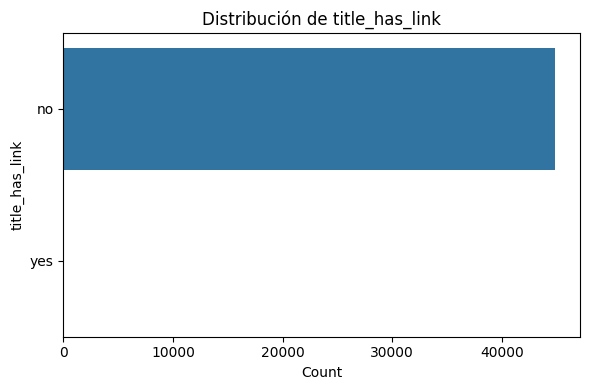

In [ ]:
import pandas as pd
import nltk
import numpy as np
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')
nltk.download('punkt_tab')

df_fake = pd.read_csv('../data/Fake.csv')
df_real = pd.read_csv('../data/True.csv')
df = pd.concat([df_fake, df_real], ignore_index=True)
# Asigna el valor 1 a las filas que provienen de df_fake y 0 a las que provienen de df_real.
df['label'] = df.index.map(lambda i: 1 if i < len(df_fake) else 0)

# 2) Numéricas (7)
df['text_length']           = df['text'].apply(len)
df['title_length']          = df['title'].apply(len)
df['num_exclamations']      = df['text'].str.count('!')
df['num_questions']         = df['text'].str.count('\?')
df['num_uppercase_words']   = df['text'].apply(lambda t: sum(1 for w in t.split() if w.isupper()))
df['num_links']             = df['text'].str.count('http')
df['num_sentences']         = df['text'].apply(lambda t: len(sent_tokenize(t)))

# 3) Categóricas (7)
df['subject'] = df['subject'].astype('category')

df['orig_date'] = df['date'].astype(str)

formats = [
    '%b %d, %Y',   # “Apr 1, 2015”
    '%B %d, %Y',  # “April 1, 2015”
    '%d %b %Y',   # “01 Apr 2015”
    '%d %B %Y',   # “01 April 2015”
    '%d-%b-%y',    # “19-Feb-18”
]

def try_parse(x):
    for fmt in formats:
        try:
            return pd.to_datetime(x, format=fmt)
        except (ValueError, TypeError):
            continue
    return pd.NaT

df['date_parsed'] = df['orig_date'].str.strip().apply(try_parse)
df['month']   = df['date_parsed'].dt.month.astype('category')
df['weekday'] = df['date_parsed'].dt.day_name().astype('category')

print("Fechas no parseadas:", df['date_parsed'].isna().sum())
print(df.loc[df['date_parsed'].isna(), 'orig_date'].unique()[:10])

# 3.4 ¿Contiene exclamación en el título?
df['title_has_exclamation'] = (df['title'].str.contains('!')).map({False:'no', True:'yes'}).astype('category')

# 3.5 ¿Contiene pregunta en el título?
df['title_has_question'] = (df['title'].str.contains('\?')).map({False:'no', True:'yes'}).astype('category')

# 3.6 Longitud del título en bins (corto/mediano/largo)
bins = [0, 30, 70, np.inf]
labels = ['short','medium','long']
df['title_length_cat'] = pd.cut(df['title_length'], bins=bins, labels=labels).astype('category')

# 3.7 ¿Hay enlaces en el título?
df['title_has_link'] = (df['title'].str.contains('http')).map({False:'no', True:'yes'}).astype('category')

# 4) Vista rápida
num_cols = ['text_length','title_length','num_exclamations','num_questions',
            'num_uppercase_words','num_links','num_sentences']
cat_cols = ['subject','month','weekday','title_has_exclamation',
            'title_has_question','title_length_cat','title_has_link']

print("Numéricas:", len(num_cols), num_cols)
print("Categóricas:", len(cat_cols), cat_cols)

print(df[num_cols].describe().T)

# 2) Histogramas para cada variable numérica
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

# 3) Conteo y porcentaje para cada variable categórica
for col in cat_cols:
    vc = df[col].value_counts(dropna=False)
    pct = df[col].value_counts(normalize=True, dropna=False) * 100
    dist = pd.DataFrame({'count': vc, 'percent': pct.round(2)})
    print(f"\n=== Distribución de {col} ===")
    display(dist)

    # Gráfico de barras
    plt.figure(figsize=(6,4))
    sns.countplot(y=col, data=df, order=vc.index)
    plt.title(f'Distribución de {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

df.to_csv('../data/processed_data.csv', index=False)



In [14]:
# Análisis y limpieza de datos faltantes/nulos

import pandas as pd

df = pd.read_csv('../data/processed_data.csv')
null_counts = df.isnull().sum()
null_percent = (null_counts / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'null_count': null_counts,
    'null_percent': null_percent
}).sort_values(by='null_percent', ascending=False)

print(missing_df)

old_length = len(df)
df = df.dropna(axis=0, how='any')
print("Filas eliminadas:", old_length - len(df))
print("Filas restantes:", len(df))


                       null_count  null_percent
weekday                        10          0.02
date_parsed                    10          0.02
month                          10          0.02
title                           0          0.00
date                            0          0.00
subject                         0          0.00
text                            0          0.00
label                           0          0.00
num_questions                   0          0.00
text_length                     0          0.00
title_length                    0          0.00
num_exclamations                0          0.00
num_sentences                   0          0.00
num_links                       0          0.00
num_uppercase_words             0          0.00
orig_date                       0          0.00
title_has_exclamation           0          0.00
title_has_question              0          0.00
title_length_cat                0          0.00
title_has_link                  0       

In [ ]:
# Encodeo de variables categóricas con OneHotEncoder

from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# 1. Carga
df = pd.read_csv('../data/processed_data.csv')
df = df.dropna(axis=0, how='any')

# 2. Columnas categóricas
cat_cols = [
    'subject','month','weekday',
    'title_has_exclamation','title_has_question',
    'title_length_cat','title_has_link'
]

# 3. Encoder 
ohe = OneHotEncoder(
    sparse_output=False,  
    drop='first',
    handle_unknown='ignore'
)


X_cat_ohe = ohe.fit_transform(df[cat_cols])
ohe_cols = ohe.get_feature_names_out(cat_cols)

X_cat_ohe = pd.DataFrame(X_cat_ohe, columns=ohe_cols, index=df.index)
num_cols = [
    'text_length','title_length','num_exclamations','num_questions',
    'num_uppercase_words','num_links','num_sentences'
]
X = pd.concat([df[num_cols], X_cat_ohe], axis=1)
y = df['label']

print("Shape de X:", X.shape)
print("Primeras 5 filas del DataFrame codificado (X):")
print(X.head())

# Correlación entre variables y variable objetivo (label)
corr = pd.concat([X, y.rename('label')], axis=1).corr()['label'].abs().sort_values(ascending=False)
print(corr.head(20))


# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # ——————————————————————————————————
# # 1. División entrenamiento / prueba
# # ——————————————————————————————————
# # Stratify para mantener la proporción de clases
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.2,        # 20% para test
#     random_state=42,
#     stratify=y
# )

# # ——————————————————————————————————
# # 2. Entrenamiento de Regresión Logística
# # ——————————————————————————————————
# model = LogisticRegression(
#     class_weight='balanced',  # compensa desbalance si existe
#     max_iter=1000,            # para asegurar convergencia
#     random_state=42
# )
# model.fit(X_train, y_train)

# # ——————————————————————————————————
# # 3. Predicción y métricas
# # ——————————————————————————————————
# # Predicción de clases y probabilidades
# y_pred  = model.predict(X_test)
# y_proba = model.predict_proba(X_test)[:, 1]

# # Reporte de clasificación
# print("=== Classification Report ===")
# print(classification_report(y_test, y_pred))

# # AUC-ROC
# auc = roc_auc_score(y_test, y_proba)
# print(f"AUC-ROC: {auc:.3f}")

# # Matriz de confusión
# cm = confusion_matrix(y_test, y_pred)
# print("=== Confusion Matrix ===")
# print(cm)

# # Opcional: visualización de la matriz de confusión
# plt.figure(figsize=(4,3))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=['Real (0)','Fake (1)'],
#             yticklabels=['Real (0)','Fake (1)'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.tight_layout()
# plt.show()



Shape de X: (44888, 35)
Primeras 5 filas del DataFrame codificado (X):
label                        1.000000
title_length_cat_medium      0.616058
subject_politicsNews         0.606197
title_length                 0.581358
subject_worldnews            0.565690
subject_News                 0.480027
subject_politics             0.404880
subject_left-news            0.317120
num_questions                0.307593
title_has_exclamation_yes    0.265562
num_exclamations             0.226890
num_links                    0.207866
title_has_question_yes       0.162796
month_11.0                   0.148078
month_9.0                    0.131634
subject_US_News              0.127277
subject_Middle-east          0.126863
month_10.0                   0.122012
weekday_Saturday             0.120739
month_12.0                   0.111117
Name: label, dtype: float64
